# Import libraries and data

In [1]:
# import libraries 
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import seaborn as sns

from sklearn.metrics import roc_auc_score, confusion_matrix
from utils import cont_variables

In [2]:
data_path = os.getcwd() + "/Datasets/"
fig_path = os.getcwd() + "/Figures/"

## Feature brain data set

In [3]:
df_features = pd.read_csv(data_path + "/Features/df_features_brain_elevated_MS_filtered.csv")

In [4]:
# drop non-sequence-based features
df_features.drop(["RNA_binding", "DNA_binding", "Ectodomain_shedding", "EV"], axis=1, inplace=True)

## CSF data set

In [5]:
csf = pd.read_csv(data_path + "CSF/csf.csv")

## DeepSec predictions

In [6]:
deepsec_test_set = pd.read_csv(data_path + "Model_comparison/Test_set_DeepSec.txt", sep="\t", header=None, 
    names=["Uniprot", "DeepSec"])

deepsec_pea = pd.read_csv(data_path + "Model_comparison/PEA_non_mass_spec_proteins_DeepSec.txt", sep="\t", header=None, 
    names=["Uniprot", "DeepSec"])

print("Number of test set proteins with DeepSec probability score:", len(deepsec_test_set))
print("Number of PEA-detected proteins with DeepSec probability score:", len(deepsec_pea))

Number of test set proteins with DeepSec probability score: 933
Number of PEA-detected proteins with DeepSec probability score: 197


## Protein test set

In [7]:
test_set = pd.read_csv(data_path + "Model_comparison/Test_set_full.txt", header=None, names=["Uniprot"])
test_set_hc = pd.read_csv(data_path + "Model_comparison/Test_set_HC.txt", header=None, names=["Uniprot"])

In [8]:
deepsec_test_set

Uniprot  DeepSec
0    Q9UPW8   0.9515
1    Q9UK28   0.5208
2    Q9H313   0.0833
3    P22303   0.9952
4    Q9P2W7   0.9420
..      ...      ...
928  Q14DG7   0.6915
929  P22304   0.9909
930  Q8N3T1   0.9968
931  Q8IY49   0.0223
932  Q14123   0.0656

[933 rows x 2 columns]

## Model and scaler

In [10]:
with open(os.getcwd() + "/Models/High_confidence_CSF.pkl", "rb") as f:  
    clf_hc = pickle.load(f)
with open(os.getcwd() + "/Models/Scaler_HC.pkl", "rb") as f:  
    scaler_hc = pickle.load(f)

# Model comparison

## Preprocess test set 

In [11]:
#  filter feature dataframe for high confidence model test set
df_features_test_set = df_features[df_features["Uniprot"].isin(test_set_hc["Uniprot"])]

# define variables and target
X = df_features_test_set.drop(["Uniprot", "Sequence", "CSF"], axis=1)
y = df_features_test_set["CSF"]

# scale test data with model scaler
X_scaler_hc = X.copy()
X_scaler_hc[cont_variables] = scaler_hc.transform(X_scaler_hc[cont_variables])
print("Number of proteins in test set:", len(X_scaler_hc))

Number of proteins in test set: 343


## Prediction results

### High confidence CSF model

In [12]:
# predict with HC-CSF classifier on test set
y_pred = clf_hc.predict(X_scaler_hc)

In [13]:
predictions = pd.DataFrame(df_features_test_set["Uniprot"])
predictions["CSF"] =  y
predictions["HC"] = clf_hc.predict_proba(X_scaler_hc)[:, 1].tolist()
predictions["HC_class"] = y_pred

### DeepSec

In [14]:
deepsec_test_set_hc = deepsec_test_set[deepsec_test_set["Uniprot"].isin(test_set_hc["Uniprot"])]
print("Number of proteins in DeepSec test set:", len(deepsec_test_set_hc))

Number of proteins in DeepSec test set: 343


In [15]:
deepsec_test_set["DeepSec_class"] = np.where(deepsec_test_set["DeepSec"] > 0.5, 1, -1)
# merge prediction results into one dataframe
predictions_comb = predictions.merge(deepsec_test_set, on="Uniprot")
predictions_comb[:5]

Uniprot  CSF        HC  HC_class  DeepSec  DeepSec_class
0  Q8TBG9   -1  0.880597         1   0.2223             -1
1  O60347   -1  0.208285        -1   0.4271             -1
2  Q9UKU6    1  0.473743        -1   0.8232              1
3  A6NC05   -1  0.161997        -1   0.0334             -1
4  Q9P2W7    1  0.595302         1   0.9420              1

## Comparison of predictions

In [16]:
print("High confidence CSF model")
print("ROC-AUC: %.4f" % roc_auc_score(predictions_comb["CSF"], predictions_comb["HC"]))
TN, FP, FN, TP = confusion_matrix(predictions_comb["CSF"], predictions_comb["HC_class"]).ravel()
print("Specificity: %.2f" %(TN / (TN+FP)*100))
print("Sensitivity: %.2f" %(TP / (TP+FN)*100))
print("--------------")

print("DeepSec model")
print("ROC-AUC: %.4f" % roc_auc_score(predictions_comb["CSF"], predictions_comb["DeepSec"]))
TN, FP, FN, TP = confusion_matrix(predictions_comb["CSF"], predictions_comb["DeepSec_class"]).ravel()
print("Specificity: %.2f" %(TN / (TN+FP)*100))
print("Sensitivity: %.2f" %(TP / (TP+FN)*100))

High confidence CSF model
ROC-AUC: 0.8900
Specificity: 85.60
Sensitivity: 76.00
--------------
DeepSec model
ROC-AUC: 0.8204
Specificity: 75.72
Sensitivity: 72.00


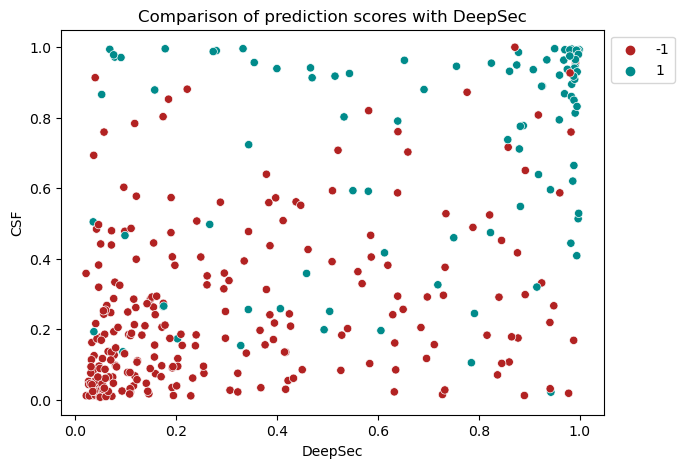

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(7,5))

sns.scatterplot(data=predictions_comb, x="DeepSec", y="HC", hue="CSF", palette=["firebrick", "darkcyan"])
plt.legend(bbox_to_anchor=(1,1))
ax.set(title="Comparison of prediction scores with DeepSec", xlabel="DeepSec", ylabel="CSF")

plt.show()

## PEA-detected CSF proteins

In [18]:
print("Fraction of correctly predicted CSF proteins: %.2f%%" % (len(deepsec_pea[deepsec_pea["DeepSec"] > 0.5]) /
    len(deepsec_pea)*100))

Fraction of correctly predicted CSF proteins: 71.57%


In [19]:
print("Median probability score:", deepsec_pea["DeepSec"].median())

Median probability score: 0.7386
